# 模型的使用代码

模型训练好了之后要实际应用。对于模型部署有很多成熟的方案，如 Nvidia 的 TensorRT， Intel 的 OpenVINO 等，都可以做模型的高效部署，这里限于篇幅不涉及相关内容。

在模型训练过程中，也可以使用使用框架提供的 API 做模型的简单部署以方便开发。

In [1]:
import tensorflow as tf
import os

首先要加载模型的标签用于展示，因为我们训练的时候就已经生成了标签文件，这里直接用写好的代码就可以。

In [2]:
if os.path.exists("labels.txt"):
    with open("labels.txt") as inf:
        classes = [l.strip() for l in inf]
else:
    classes = os.listdir("worddata/train/")
    with open("labels.txt", "w") as of:
        of.write("\r\n".join(classes))

接着是模型的定义，这里直接将训练中使用的模型代码拿来即可。

In [3]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.feature = tf.keras.models.Sequential()
        self.feature.add(self.conv(64))
        self.feature.add(self.conv(64, add_pooling=True))

        self.feature.add(self.conv(128))
        self.feature.add(self.conv(128, add_pooling=True))

        self.feature.add(self.conv(256))
        self.feature.add(self.conv(256))
        self.feature.add(self.conv(256, add_pooling=True))

        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512, add_pooling=True))

        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512, add_pooling=True))

        self.feature.add(tf.keras.layers.GlobalAveragePooling2D())

        self.feature.add(tf.keras.layers.Dense(4096))
        self.feature.add(tf.keras.layers.BatchNormalization())
        self.feature.add(tf.keras.layers.Dense(4096))
        self.feature.add(tf.keras.layers.BatchNormalization())

        self.feature.add(tf.keras.layers.Dropout(0.5))

        self.pred = tf.keras.models.Sequential(
            [tf.keras.layers.Dense(100, activation=None), tf.keras.layers.Softmax(),]
        )

    def conv(self, filters, add_pooling=False):
        model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu"),
                tf.keras.layers.BatchNormalization(),
            ]
        )
        if add_pooling:
            model.add(
                tf.keras.layers.MaxPool2D(
                    pool_size=(2, 2), strides=None, padding="same"
                )
            )
        return model

    def call(self, x):
        x = self.feature(x)
        return self.pred(x)

有了模型的定义之后，我们可以加载训练好的模型，跟模型训练的时候类似，我们可以直接加载模型训练中的 checkpoint。

In [4]:
model = MyModel()
ckpt = tf.train.get_checkpoint_state("./ckpts/")
if ckpt:
    model.load_weights(ckpt.model_checkpoint_path)
    print("model lodaded")

model lodaded


对于数据，我们需要直接处理图片，因此这里导入一些图片处理的库和数据处理的库

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

直接打开某个图片

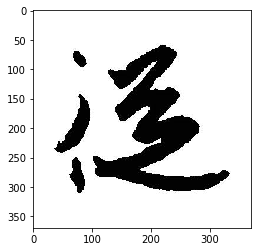

In [6]:
img = Image.open("worddata/validation/从/116e891836204e4e67659d2b73a7e4780a37c301.jpg")

plt.imshow(img, cmap="gray")

需要注意，模型在训练的时候，我们对数据进行了一些处理，在模型使用的时候，我们要对数据做一样的处理，如果不做的话，模型最终的结果会出现不可预料的问题。

In [7]:
img = img.resize((128, 128))
img = np.array(img) / 255
img.shape

(128, 128)

模型对图片数据的运算其实很简单，一行代码就可以。

> 这里需要注意模型处理的数据是 4 维的，而上面的图片数据实际是 2 维的，因此要对数据进行维度的扩充。同时模型的输出是 2 维的，带 batch ，所以需要压缩一下维度。

In [10]:
pred = np.squeeze(model(img[np.newaxis, :, :, np.newaxis], training=False))
pred.argsort()[-5:]

print([pred[idx] for idx in pred.argsort()[-5:]])
print([classes[idx] for idx in pred.argsort()[-5:]])

[0.0016498895, 0.0019593597, 0.0038452102, 0.009729111, 0.9795379]
['御', '起', '游', '流', '从']


这里只给出了 top5 的结果，可以看到，准确率还是不错的。